In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os



In [2]:
import sys
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

In [3]:
counts = pd.read_csv('data/star_counts.tab.gz', sep='\t', index_col=0)
rd = pd.read_csv('data/rd_pc2.tab.gz', sep='\t', index_col=0)
meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0)
star_meta = pd.read_csv('data/star_meta.tab.gz', sep='\t', index_col=0)

discard = ['EGFP'] + [x for x in counts.index if x[:5]=='ERCC-']
good_genes = [x for x in counts.index if x not in discard]
counts = counts.loc[good_genes, rd.index].T

In [4]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)

In [7]:
!pip install scikit-misc

     |████████████████████████████████| 8.7 MB 13.0 MB/s eta 0:00:01


In [18]:
adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

gene_len = gene_len.reindex(adata.var.index).dropna()
adata = adata[:, gene_len.index]
assert (adata.var.index == gene_len.index).sum() == adata.shape[1]
adata.X = adata.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
adata.X = np.rint(adata.X)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata.obs['Age'] = meta.loc[adata.obs.index].Age
adata.obs['Genotype']  = meta.loc[adata.obs.index].Genotype
adata.obs['spike']  = meta.loc[adata.obs.index, 'spike-in']

batch = list(zip(meta.loc[adata.obs.index].Genotype, meta.loc[adata.obs.index, 'spike-in']))
batch = ['_'.join(x) for x in batch]

adata.obs['batch'] = batch

scvi.data.setup_anndata(adata, layer="counts")



sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    batch_key="Genotype",
    flavor="seurat_v3"
)


/mnt/lareaulab/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 15612 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [19]:
scvi.data.setup_anndata(adata, layer="counts")
scvi.settings.seed = 0
model = scvi.model.LinearSCVI(adata, n_latent=3)


model.train()


# model.save("tiklova_neurogenesis/")

# model = scvi.model.LinearSCVI.load("my_model/", adata)

latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")

sc.tl.pca(adata)



INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [03:43<00:00,  1.79it/

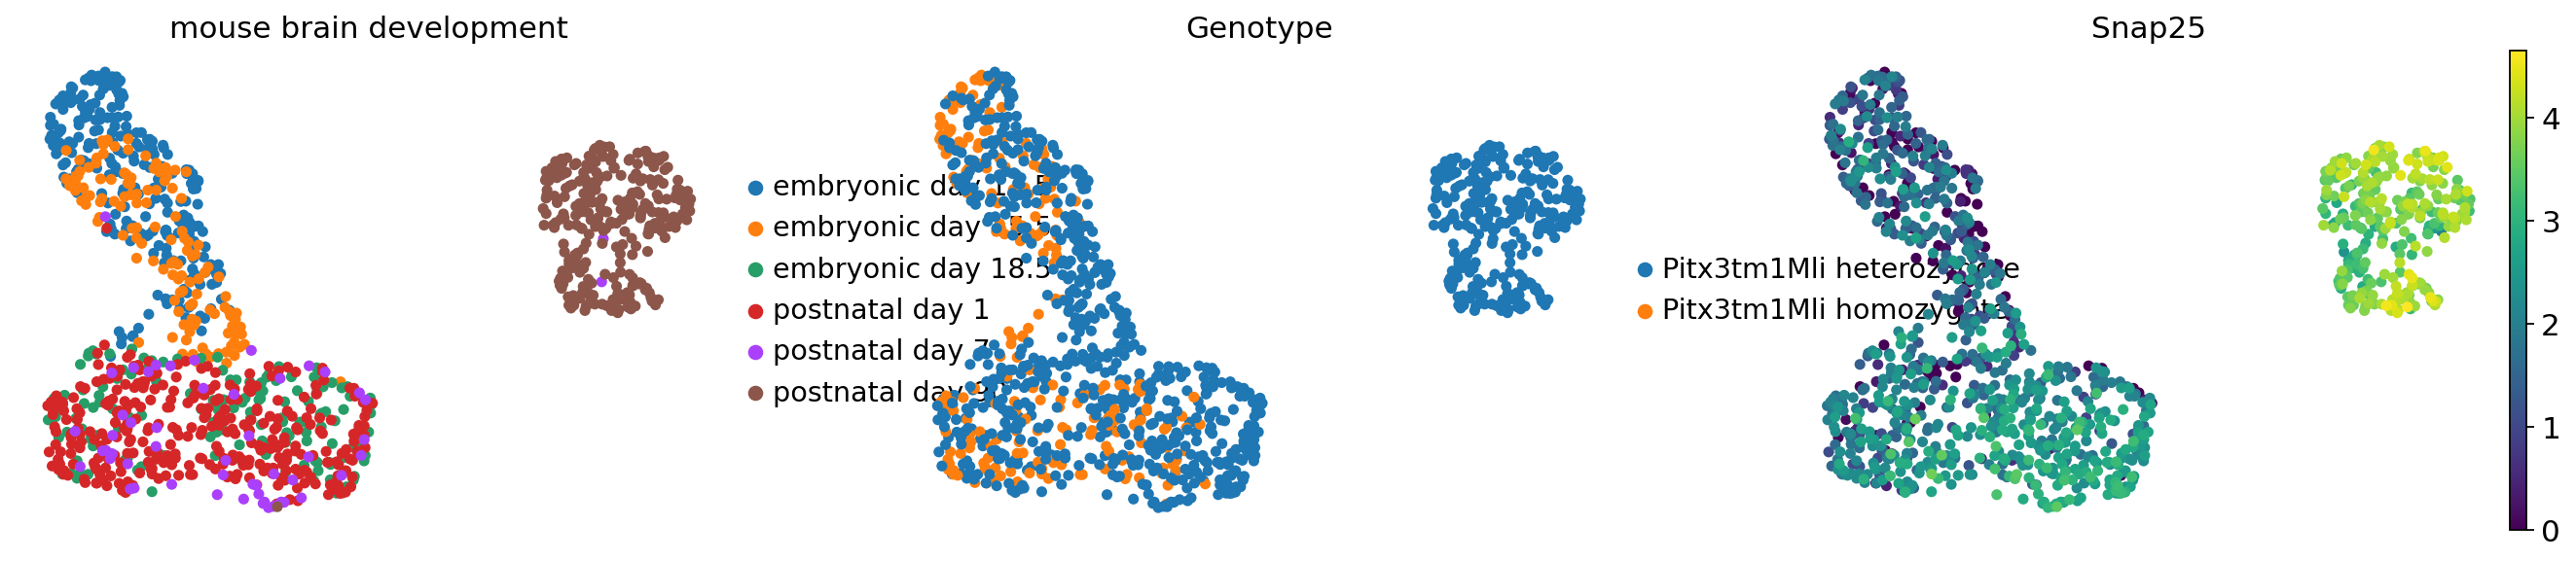

In [23]:
sc.set_figure_params(figsize=(6, 4))

sc.tl.umap(adata, min_dist=0.5)

sc.pl.umap(
    adata,
    color=["Age", 'Genotype', 'Snap25'],
    frameon=False,
    title='mouse brain development'
)


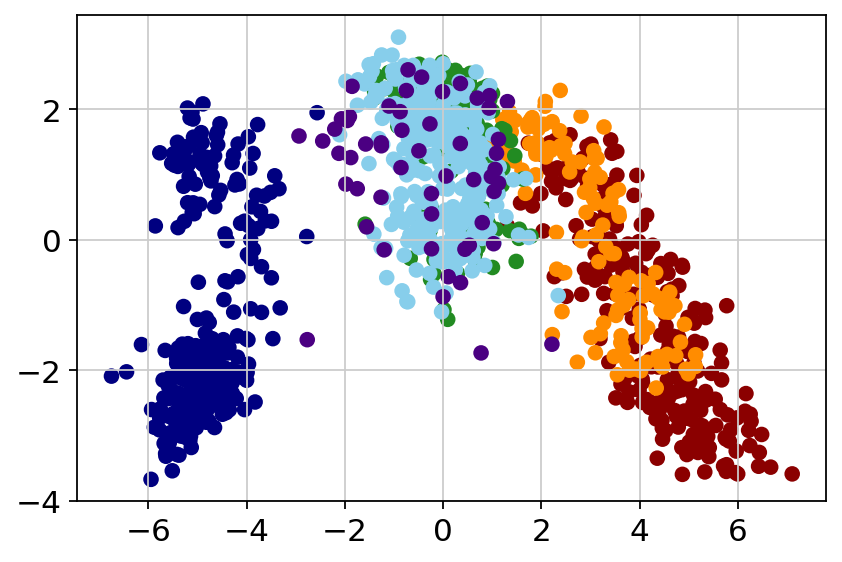

In [21]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])
plt.scatter(pc.T[0], -pc.T[1], c=colores)

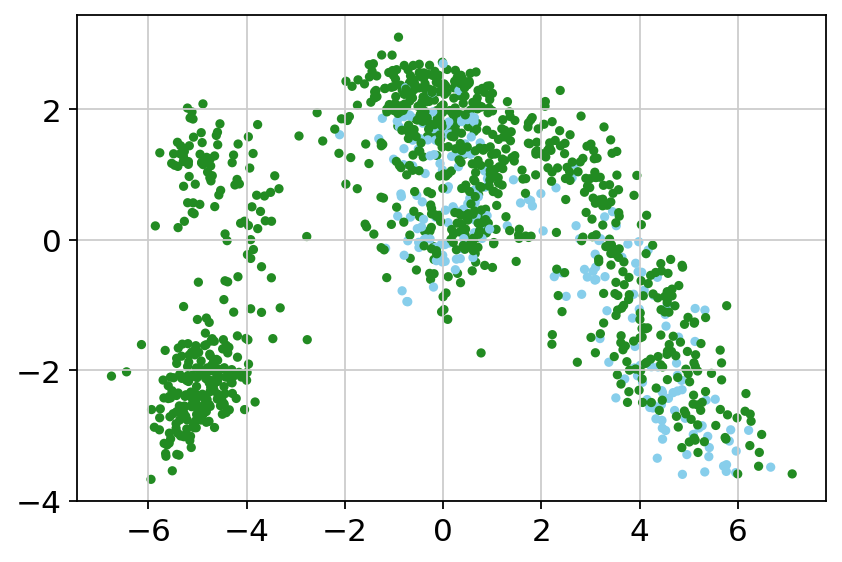

In [22]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Genotype:
    if cell == 'Pitx3tm1Mli homozygote':
        colores.append('skyblue')
    else:

        colores.append('forestgreen')
        
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])
plt.scatter(pc.T[0], -pc.T[1], c=colores, s=10)

In [13]:
meta.Genotype.unique()

array(['Pitx3tm1Mli homozygote', 'Pitx3tm1Mli heterozygote'], dtype=object)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1197 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


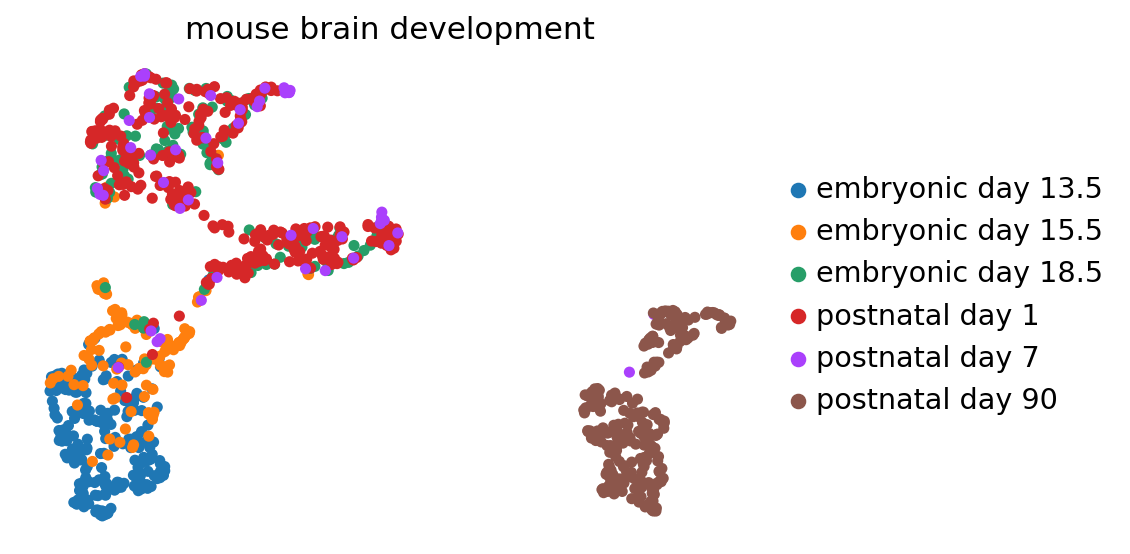

In [152]:
# model = scvi.model.LinearSCVI.load("tiklova_scvi3/", adata)


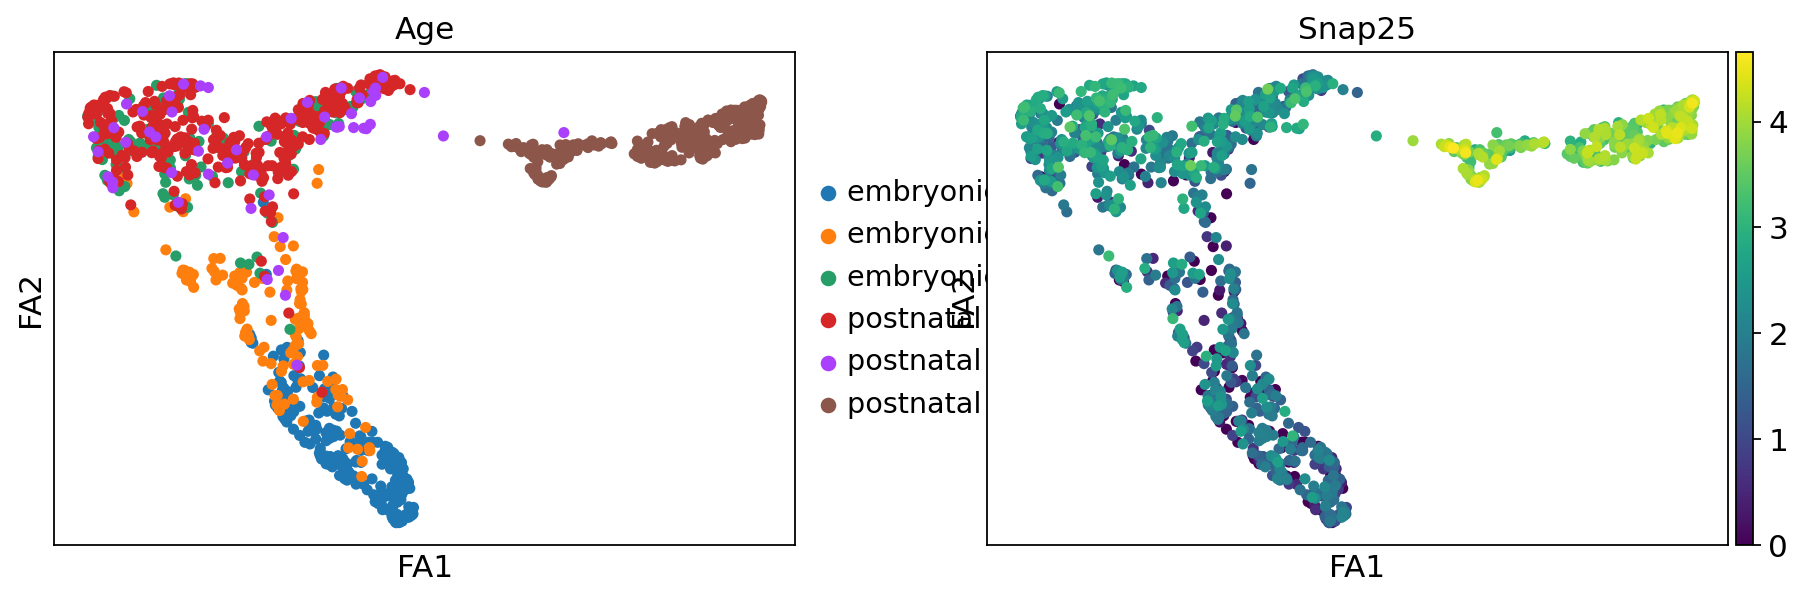

In [153]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['Age', 'Snap25'])

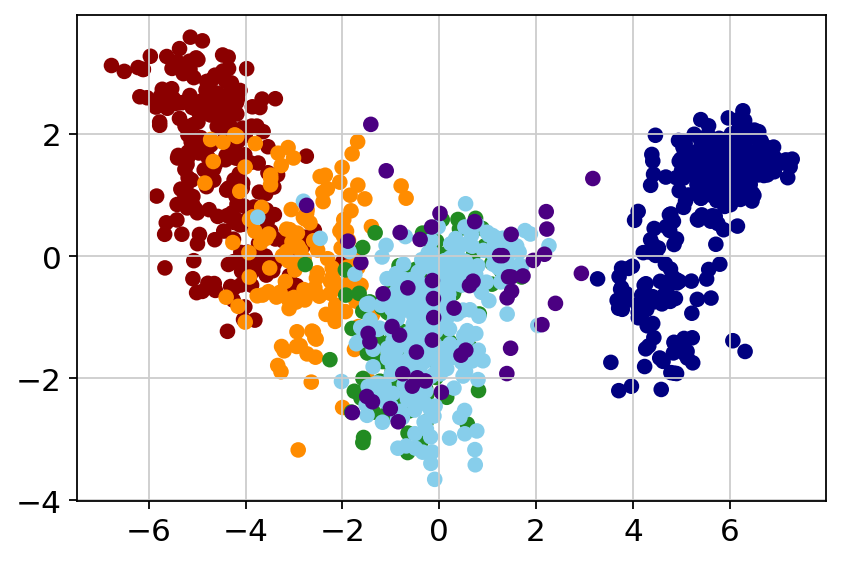

In [70]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])
plt.scatter(pc.T[0], -pc.T[1], c=colores)

In [54]:
model.save("tiklova_scvi3/")
adata.write_csvs('tiklova_scvi3_anndata')

scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 4)]

scvi_rd.to_csv('tiklova_scvi3_rd.tab', sep='\t', index=True, header=True)

In [ ]:
plt.scatter(adata.obsm['X_scVI'].T[1], adata.obsm['X_scVI'].T[2], c=colores)

In [163]:
scvi.data.setup_anndata(adata, layer="counts")
scvi.settings.seed = 0
model = scvi.model.LinearSCVI(adata, n_latent=5)


model.train()


# model.save("tiklova_neurogenesis/")

# model = scvi.model.LinearSCVI.load("my_model/", adata)

latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")

sc.tl.pca(adata)



INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [00:55<00:00,  7.24it/

... storing 'Age' as categorical


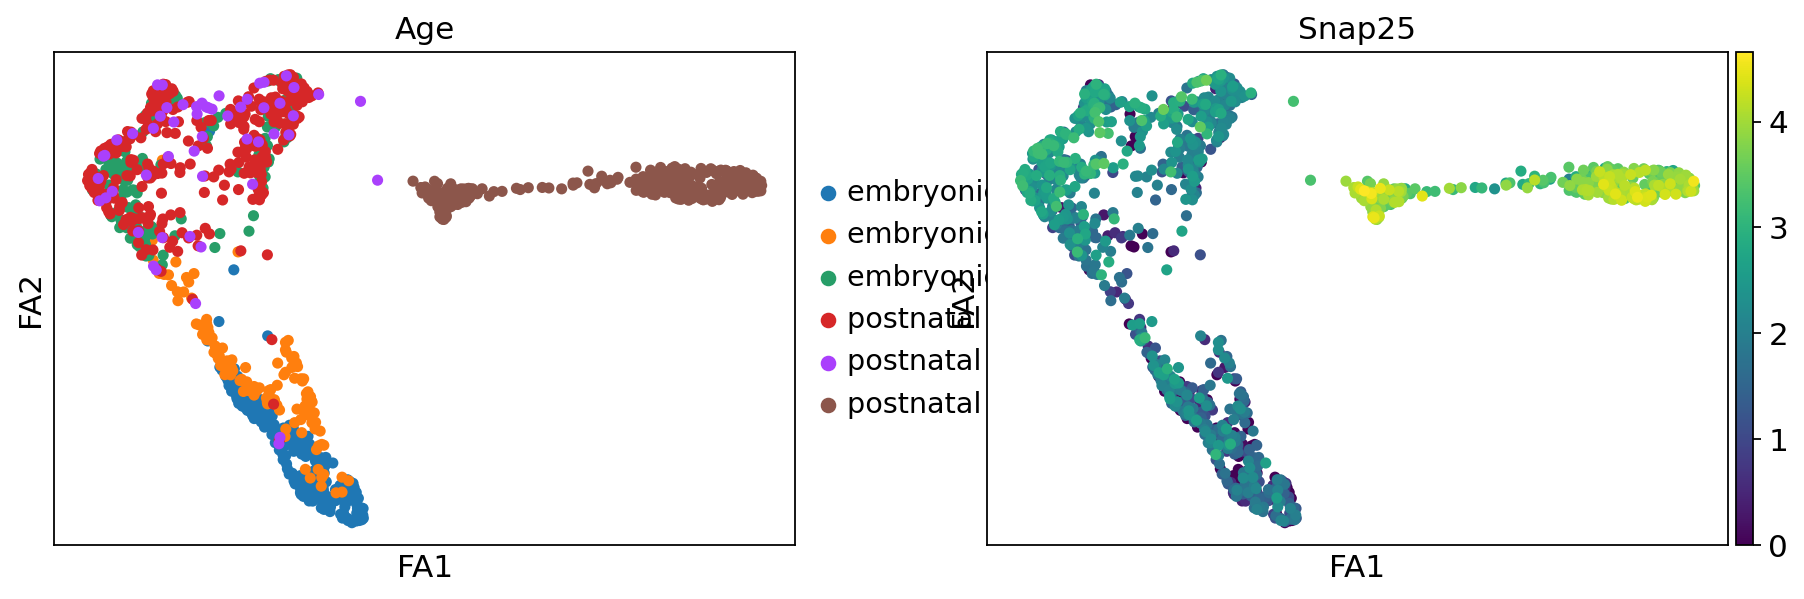

In [164]:
sc.tl.draw_graph(adata, color=['Age', 'Snap25'])
sc.pl.draw_graph(adata, color=['Age', 'Snap25'])

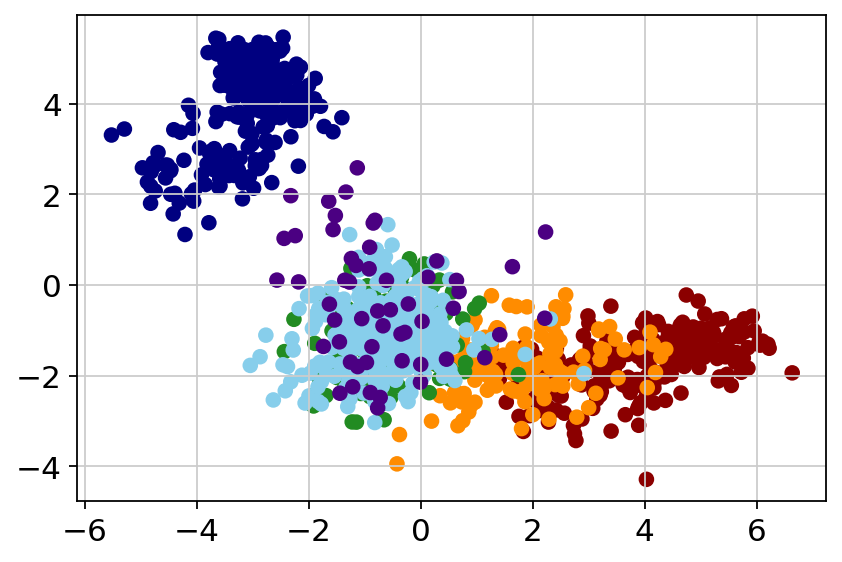

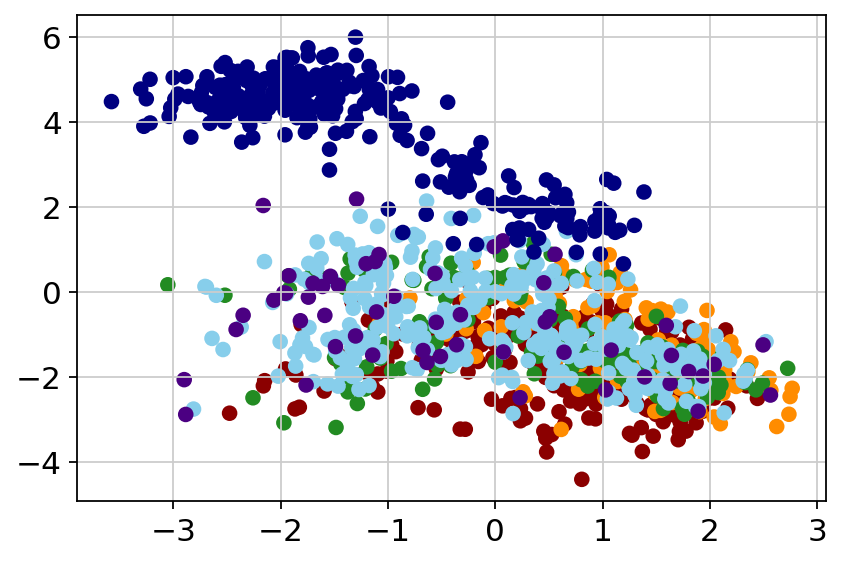

In [45]:
plt.scatter(adata.obsm['X_scVI'].T[1], adata.obsm['X_scVI'].T[0], c=colores)

# batch correction

In [96]:



adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

gene_len = gene_len.reindex(adata.var.index).dropna()
adata = adata[:, gene_len.index]
assert (adata.var.index == gene_len.index).sum() == adata.shape[1]
adata.X = adata.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
adata.X = np.rint(adata.X)


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata.obs['Age'] = meta.loc[adata.obs.index].Age


new_batch = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        new_batch.append(0)
    elif cell == 'embryonic day 15.5':
        new_batch.append(1)
    elif cell == 'embryonic day 18.5':
        new_batch.append(2)
    elif cell == 'postnatal day 1':
        new_batch.append(3)
    elif cell == 'postnatal day 7':
        new_batch.append(4)
    elif cell == 'postnatal day 90':
        new_batch.append(5)
        
adata.obs['batch'] = new_batch

scvi.data.setup_anndata(adata, layer="counts")



sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    batch_key="batch",
    flavor="seurat_v3"
)


scvi.data.setup_anndata(adata, layer="counts")
scvi.settings.seed = 0
model = scvi.model.LinearSCVI(adata, n_latent=5)


model.train()


# model.save("tiklova_neurogenesis/")

# model = scvi.model.LinearSCVI.load("my_model/", adata)

latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")




/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 15612 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [00:53<00:00,  7.51it/

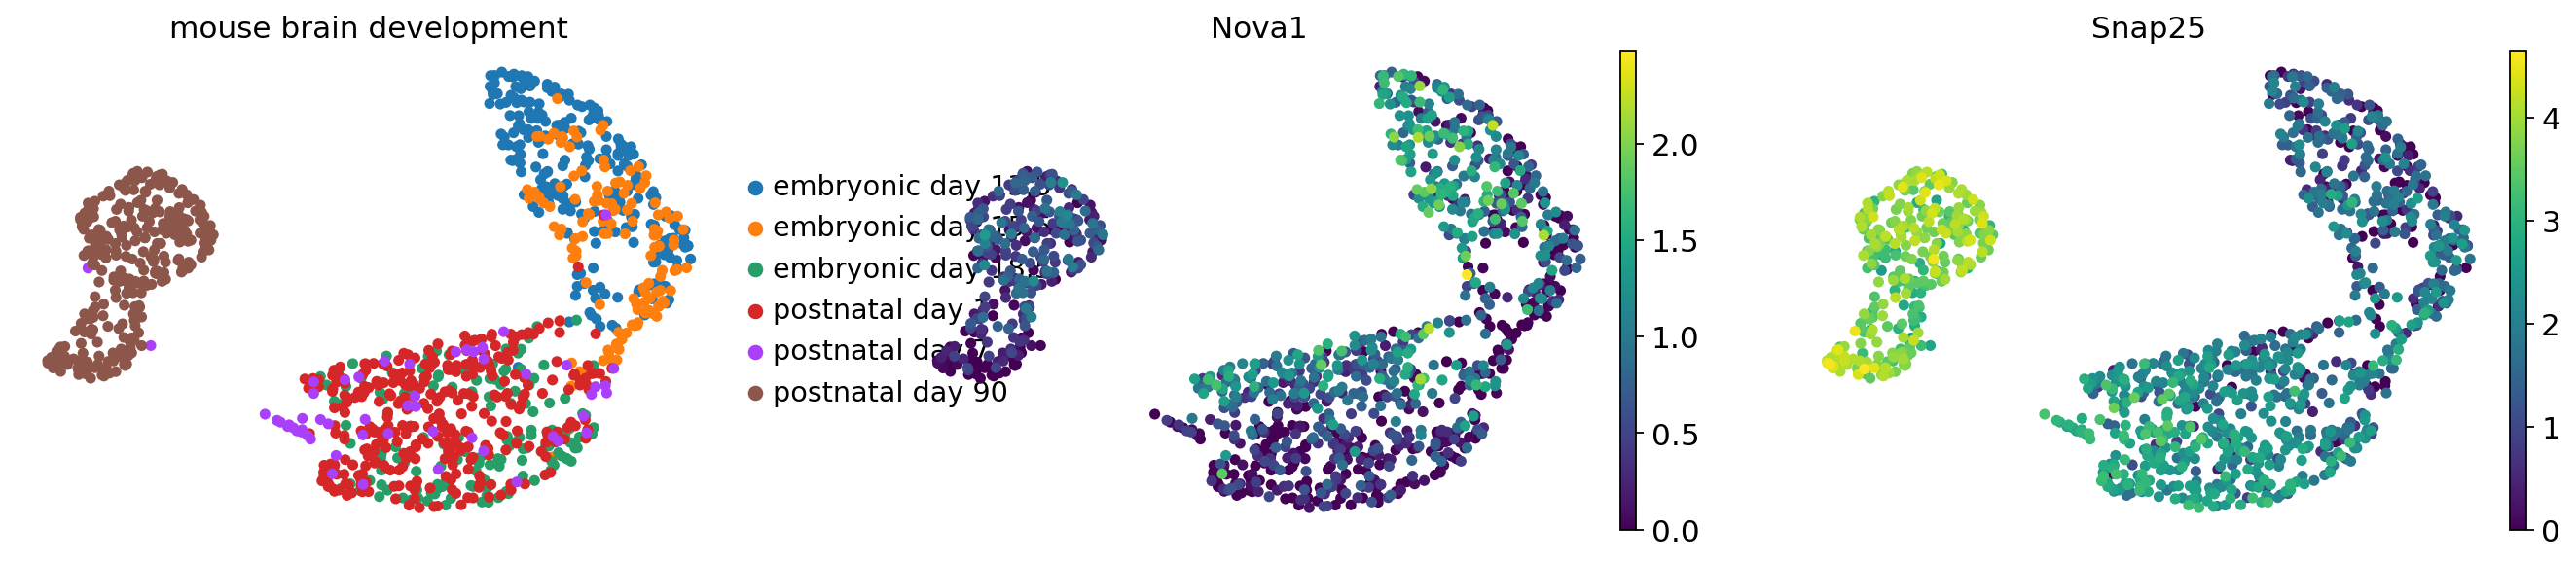

In [102]:
sc.set_figure_params(figsize=(6, 4))

sc.tl.umap(adata, min_dist=0.5)

sc.pl.umap(
    adata,
    color=["Age", 'Nova1', 'Snap25'],
    frameon=False,
    title='mouse brain development'
)


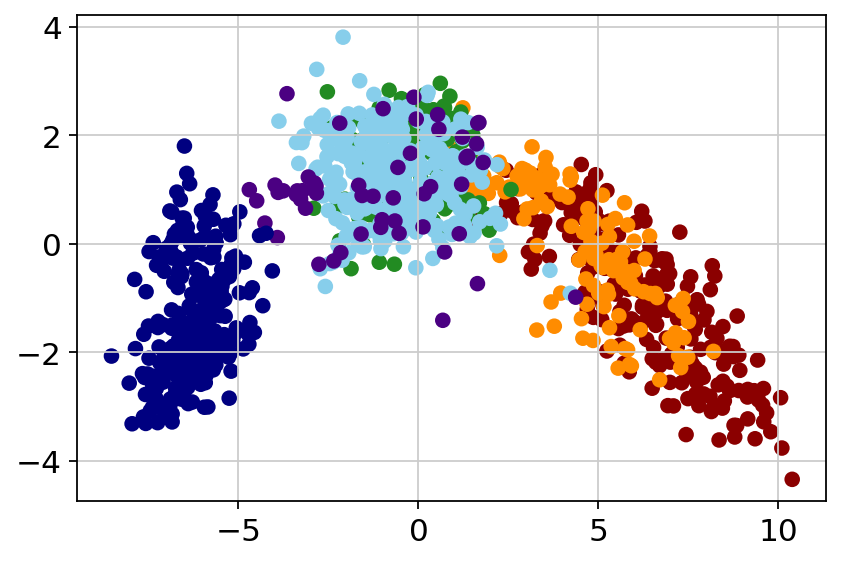

In [103]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])
plt.scatter(pc.T[0], -pc.T[1], c=colores)

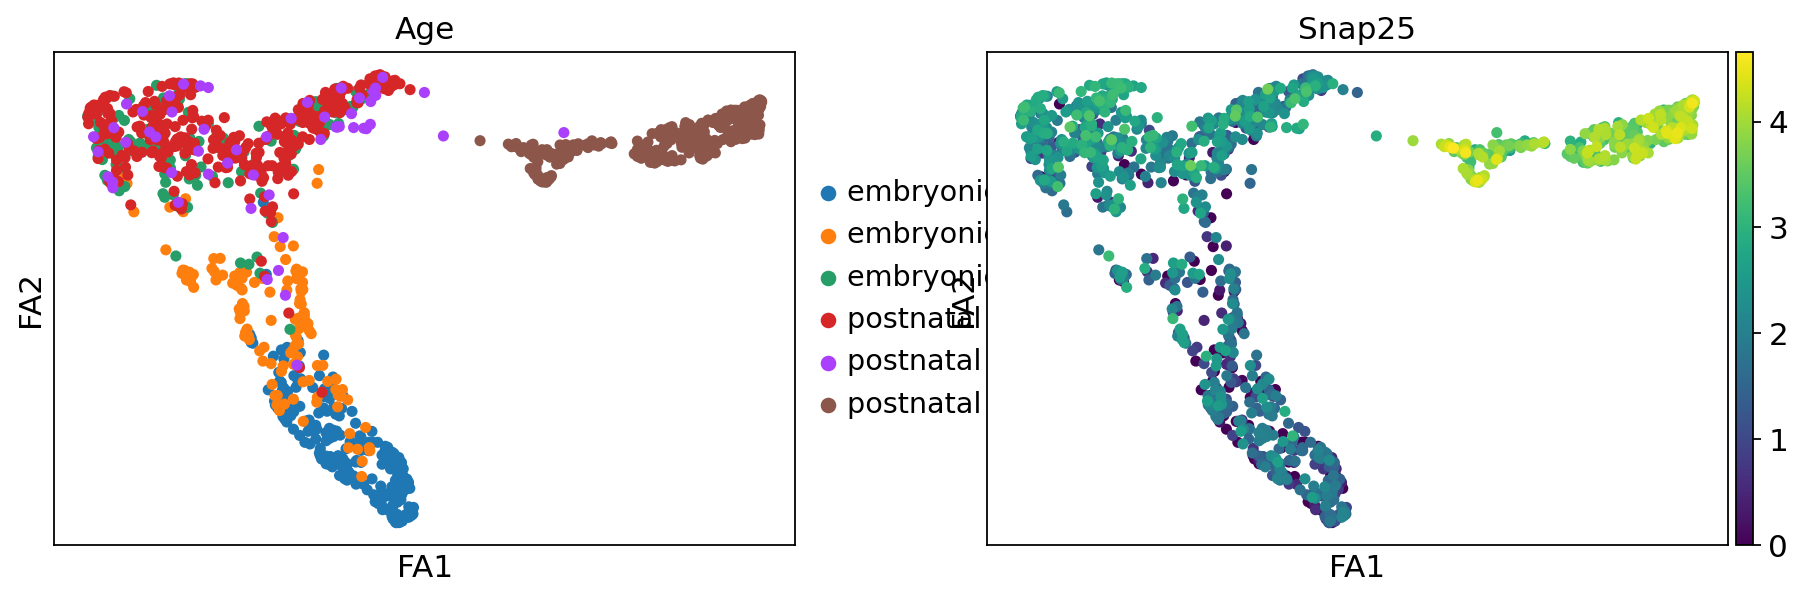

In [147]:
# !pip install fa2
sc.tl.draw_graph(adata, color=['Age', 'Snap25'])
sc.pl.draw_graph(adata, color=['Age', 'Snap25'])

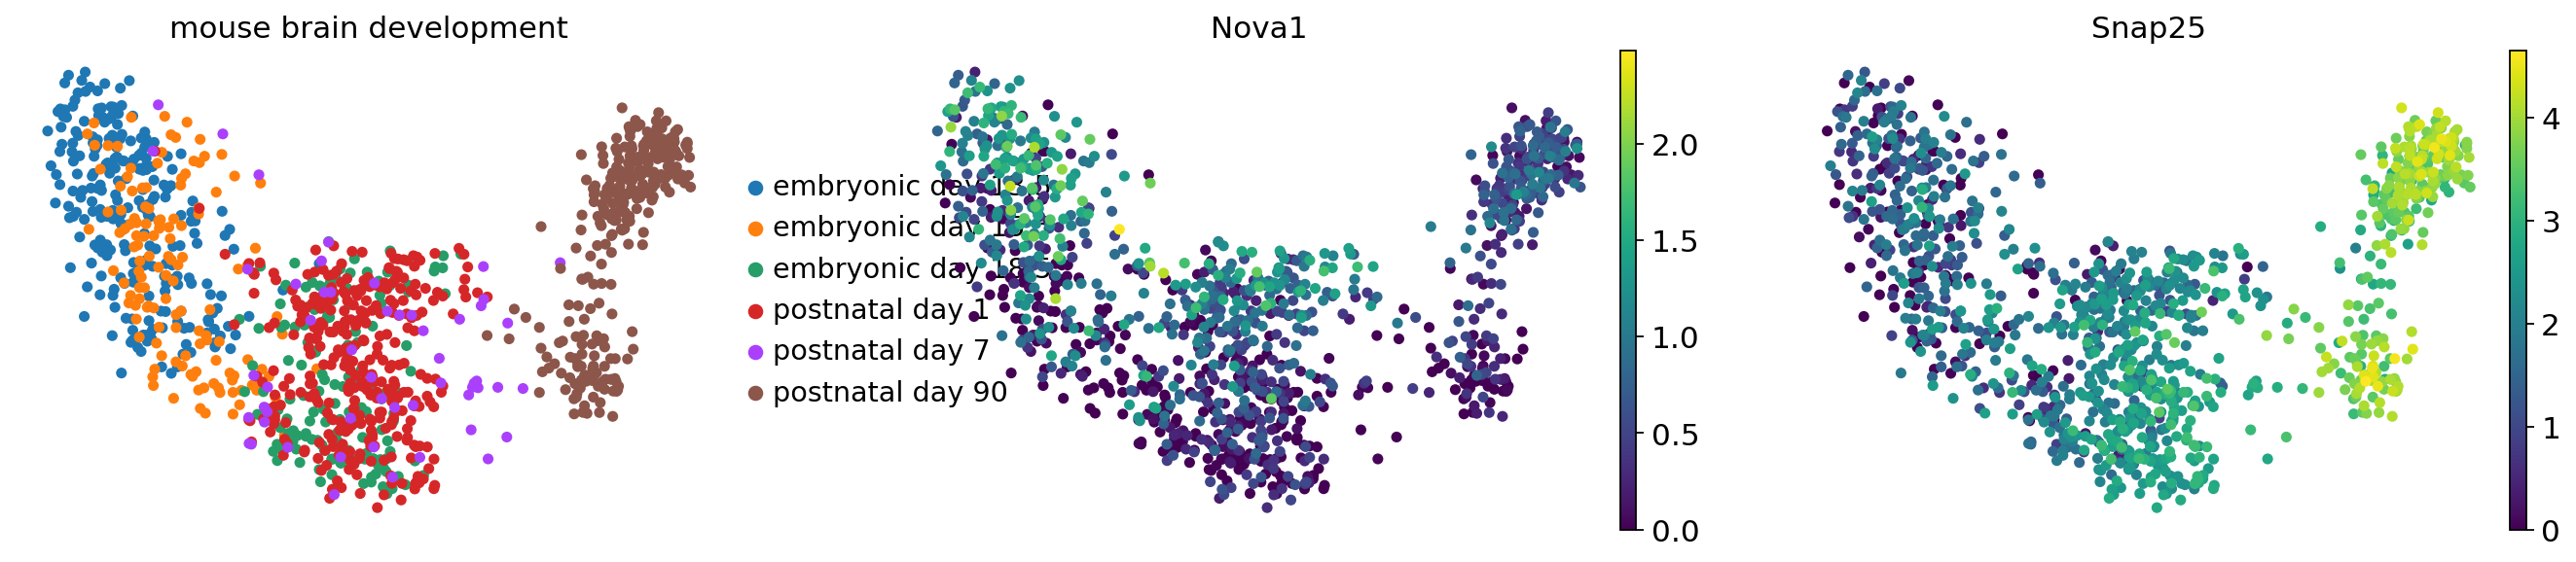

In [117]:
sc.pl.pca(
    adata,#.obsm['X_scVI'],
    color=["Age", 'Nova1', 'Snap25'],
    frameon=False,
    title='mouse brain development'
)


In [106]:
model.save("tiklova_scvi5_batch/")
adata.write_csvs('tiklova_scvi5_batch_anndata')

scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 6)]

scvi_rd.to_csv('tiklova_scvi5_batch_rd.tab', sep='\t', index=True, header=True)

writing .csv files to tiklova_scvi5_batch_anndata


# Latent components

In [76]:
de_df = model.differential_expression(
    groupby="Age",
)

DE...: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]


In [77]:
markers = {}
cats = adata.obs.Age.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    Age_df = de_df.loc[de_df.comparison == cid]
    Age_df = Age_df.sort_values("lfc_mean", ascending=False)

    Age_df = Age_df[Age_df.lfc_mean > 0]

    Age_df = Age_df[Age_df["bayes_factor"] > 3]
    Age_df = Age_df[Age_df["non_zeros_proportion1"] > 0.1]

    markers[c] = Age_df.index.tolist()[:3]

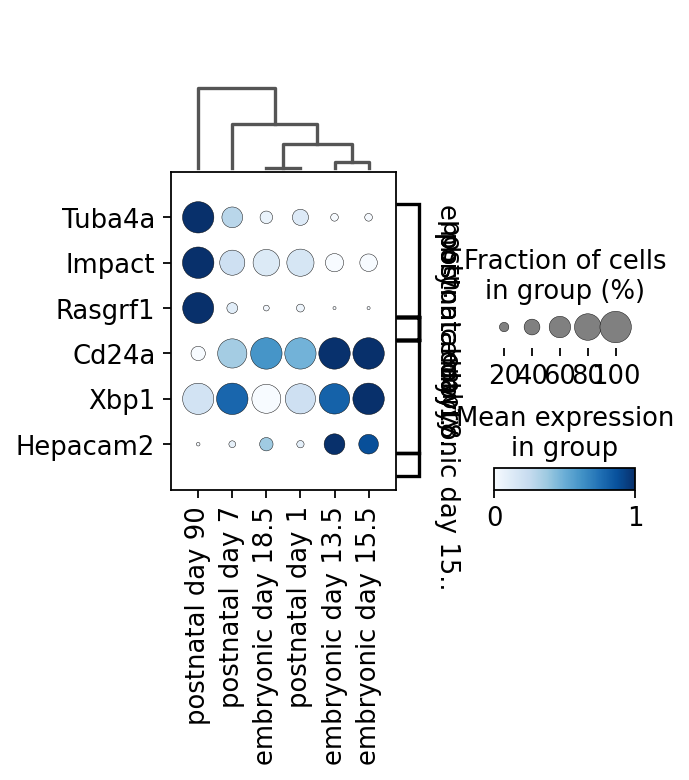

In [79]:
sc.set_figure_params(figsize=(8, 6))

sc.tl.dendrogram(adata, groupby="Age", use_rep="X_scVI")

sc.pl.dotplot(
    adata,
    markers,
    groupby='Age',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


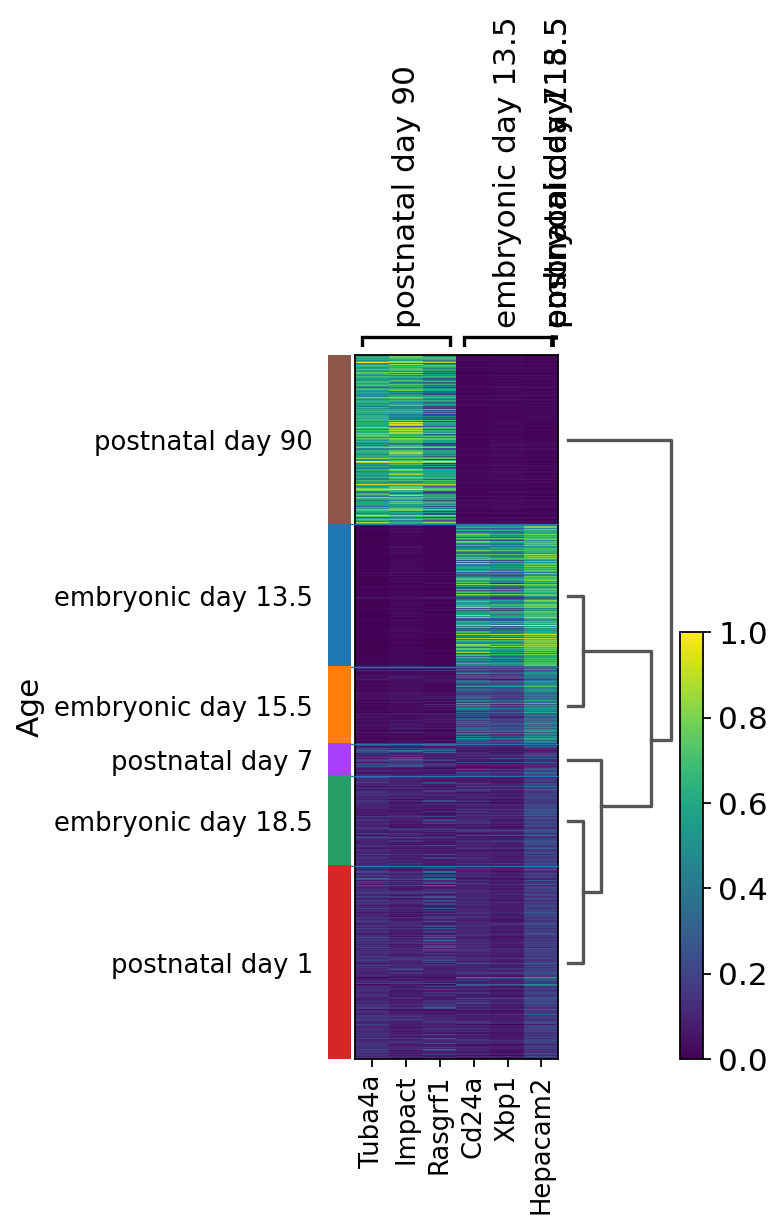

In [80]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='Age',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
)

In [4]:
scvi.__version__

'0.8.1'